In [1]:
#IMPORTACIONES
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

GRAFICO 1 - RESUMEN PERFORMANCE ECONOMICA

<ipython-input-2-2b0ce8d13b2b>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ipc_ng_nacional_tasa_variacion_mensual"].iloc[0]=100


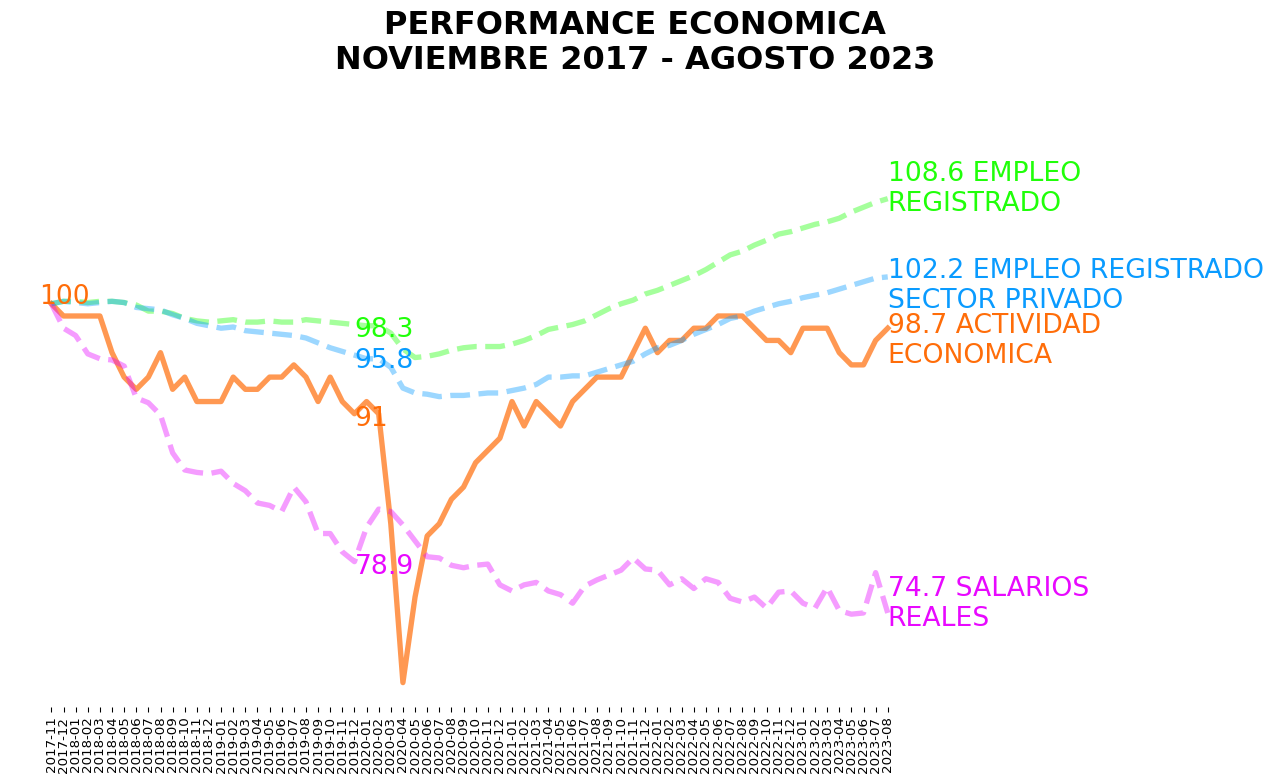

In [2]:
#En este gráfico se busca mostrar la evolución de ciertos indicadores economicos en el periodo que va desde el mes con mayor nivel de actividad economica (EMAE)
#del gobierno anterior (MACRI), hasta el ultimo mes con información disponible.

#Los indicadores son: Nivel de empleo registrado, Nivel de empleo registrado en el sector privado, Nivel de Actividad economica, y Nivel del Salario real
#Los tres primeros indicadores se obtienen directamente de los dataset, pero el salario real se obtiene deflactando por inflacion los valores del dataset


#DATASETS
EMAE = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/143/distribution/143.3/download/emae-valores-anuales-indice-base-2004-mensual.csv")
TRA = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/151/distribution/151.1/download/trabajadores-registrados-modalidad-ocupacional-principal-mensual-total-pais-miles-base-2012.csv")
ISAL = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/149/distribution/149.1/download/indice-salarios-periodicidad-mensual-base-octubre-2016.csv")
IPC = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/145/distribution/145.3/download/indice-precios-al-consumidor-nivel-general-base-diciembre-2016-mensual.csv")

#DEFINICION DEL PERIODO A ANALIZAR (fecha inicial y fecha final)
#la fecha final es el ultimo mes con info disponible del nivel de actividad economica
#iloc permite acceder al valor usando el número de posición
fecha_final=EMAE['indice_tiempo'].iloc[-1]
#la fecha inicial es el mes en el que el EMAE muestra un mayor nivel durante el gobierno anterior
#filtramos para que solo queden los datos de ese periodo de gobierno y ordenamos de menor a mayor usando la columna relevante
fecha_inicial=EMAE[(EMAE.indice_tiempo > "2015-12-01") & (EMAE.indice_tiempo < "2020-01-01")].sort_values(by='emae_desestacionalizada')
fecha_inicial= fecha_inicial.indice_tiempo.iloc[-1]

#CALCULO DEL SALARIO REAL
#armo un nuevo dataframe donde queden ordenados por periodo de tiempo el df que contiene la info de salarios y el que contiene datos de inflacion
dfs=[ISAL, IPC]
df = reduce(lambda  left,right: pd.merge(left,right,on=['indice_tiempo'],how='outer'), dfs)
#recorto el df para que solo incluya el periodo entre fecha_inicial y fecha_final. Tambien uso reset_index porque despues me va a servir para usar loc,
#que permite acceder a los valores usando el indice
df=df.loc[(df['indice_tiempo'] >= fecha_inicial) & (df['indice_tiempo'] <= fecha_final)].reset_index()
#Para calcular la serie de salario real necesito:
#1-construir serie de inflacion acumulada
#para construir indice de inflacion base 100 pongo 100 en el valor inicial de la serie
df["ipc_ng_nacional_tasa_variacion_mensual"].iloc[0]=100
#mediante el siguiente for loop reemplazo los valores de inflacion mensual del dataset (a partir de la segunda posicion) por los valores de inflacion acumulada
for i in range(1, len(df)):
  df.loc[i,'ipc_ng_nacional_tasa_variacion_mensual'] = df.loc[i-1,'ipc_ng_nacional_tasa_variacion_mensual'] * (df.loc[i,'ipc_ng_nacional_tasa_variacion_mensual'] + 1)
#2-dividir el valor nominal del indice de salario por el valor de la inflacion acumulada corresspondiente, dividido el valor inicial de la serie de inflacion (100)
#Esto es "Salario_real_mes_x"="Salario_nominal_mes_x"/("Inflacion_acumulada_mes_x"/"Inlfacion_acumulada_mes_0")
#armo una nueva columna "calculo" donde copio cada valor de inflacion acumulada, dividido el valor inicial de la serie de inflacion.
df["calculo"]=df.loc[:,'ipc_ng_nacional_tasa_variacion_mensual'].div(df.iloc[0]['ipc_ng_nacional_tasa_variacion_mensual'])
#a continuacion, defino una formula que me va a permitir ademas de realizar la operacion faltante para el calculo del salario real de cada mes,
#calcular la variacion porcentual del salario real mes a mes, que es necesario para construir el indice de variacion de salario real
def prueba (number):
    return number.div(df["calculo"].values).pct_change()
columnas_corrientes=['indice_salarios']
df[columnas_corrientes] = df[columnas_corrientes].apply(prueba)
#ahora construyo el indice de salario real
df.loc[0, columnas_corrientes]=100
for i in range(1, len(df)):
  df.loc[i, columnas_corrientes] = df.loc[i-1, columnas_corrientes] * (df.loc[i, columnas_corrientes]+1)

#CALCULO DE LAS SERIES PARA LOS CUATRO INDICADORES
#una vez cumplido el calculo del salario real, construimos las series de todos los indicadores
#selecciono las columnas relevantes y armo un nuevo dataframe donde queden ordenados por periodo de tiempo
indicadores=["emae_desestacionalizada", "total_sin_estac", "asalariados_priv_sin_estac", "indice_salarios"]
dfs=[EMAE,TRA, df]
df = reduce(lambda  left,right: pd.merge(left,right,on=['indice_tiempo'],how='outer'), dfs)
df=df.loc[(df['indice_tiempo'] >= fecha_inicial) & (df['indice_tiempo'] <= fecha_final)].reset_index()
#calculo las variaciones porcentuales mensuales para cada indicador
def prueba (number):
    return number.pct_change()
df[indicadores] = df[indicadores].apply(prueba)
df.loc[0, indicadores]=100
for i in range(1, len(df)):
  df.loc[i, indicadores] = df.loc[i-1, indicadores] * (df.loc[i, indicadores]+1)

#GRAFICO
fig = plt.figure(figsize=(13.33,7.5), dpi=96)

#defino las variables a graficar
x=df["indice_tiempo"].str[:7]
y1=df["emae_desestacionalizada"].astype(int)
y2=df["total_sin_estac"].round(1)
y3=df["asalariados_priv_sin_estac"].round(1)
y4=df["indice_salarios"].round(1)

#defino las lineas y sus caracteristicas
plt.plot(x, y1, color="#ff6d09", linewidth=4, alpha=0.7)
plt.plot(x, y2, color='#20FF09', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y3, color='#099BFF', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y4, color='#E809FF', linewidth=4, alpha=0.4, linestyle='dashed')

#etiquetas eje x rotadas
plt.tick_params(axis='x', rotation=90)
#saco los ejes x e y
plt.box(False)
#saco las etiquetas del eje y
plt.yticks([])

#anotaciones en el grafico
valor_indice=x[x == "2019-12"].index[0]
plt.text(x.tail(1), y2.tail(1)-1, df["total_sin_estac"].iloc[-1].round(1).astype(str)+" EMPLEO\nREGISTRADO", horizontalalignment='left', color='#20FF09', fontsize=20)
plt.text(x.tail(1), y3.tail(1)-2.5, df["asalariados_priv_sin_estac"].iloc[-1].round(1).astype(str)+" EMPLEO REGISTRADO\nSECTOR PRIVADO", horizontalalignment='left', color='#099BFF', fontsize=20)
plt.text(x.tail(1), y4.tail(1)-1, df["indice_salarios"].iloc[-1].round(1).astype(str)+" SALARIOS\nREALES", horizontalalignment='left', color='#E809FF', fontsize=20)
plt.text(x.tail(1), y1.tail(1)-2.8, df["emae_desestacionalizada"].iloc[-1].round(1).astype(str)+" ACTIVIDAD\nECONOMICA", horizontalalignment='left', color='#ff6d09', fontsize=20)
plt.text(-1, y1.head(1), "100", horizontalalignment='left', color='#ff6d09', fontsize=20)
plt.text("2019-12", y1[valor_indice]-1, y1[valor_indice].astype(str), horizontalalignment='left',  color='#ff6d09', fontsize=20)
plt.text("2019-12", y2[valor_indice]-1, y2[valor_indice].astype(str), horizontalalignment='left',  color='#20FF09', fontsize=20)
plt.text("2019-12", y3[valor_indice]-1, y3[valor_indice].astype(str), horizontalalignment='left',  color='#099BFF', fontsize=20)
plt.text("2019-12", y4[valor_indice]-1, y4[valor_indice].astype(str), horizontalalignment='left',  color='#E809FF', fontsize=20)

#funcion que genera el nombre de un mes en el grafico
EMAE["nombre_mes"]=EMAE["indice_tiempo"].str[5:7]
meses = {"01":"ENERO","02":"FEBRERO","03":"MARZO","04":"ABRIL","05":"MAYO","06":"JUNIO","07":"JULIO","08":"AGOSTO","09":"SEPTIEMBRE","10":"OCTUBRE","11":"NOVIEMBRE","12": "DICIEMBRE"}
EMAE['nombre_mes'].replace(meses, inplace=True)

my_suptitle = fig.suptitle("PERFORMANCE ECONOMICA\n"+meses[fecha_inicial[5:7]]+" "+fecha_inicial[:4]+" - "+EMAE["nombre_mes"].iloc[-1]+" "+
                           EMAE["indice_tiempo"].str[:4].iloc[-1], fontsize=24,fontweight="bold",y=1.08, color="black")
plt.tight_layout()

plt.show()

GRAFICO 2 - EVOLUCION INGRESOS (INDICE SALARIOS INDEC)

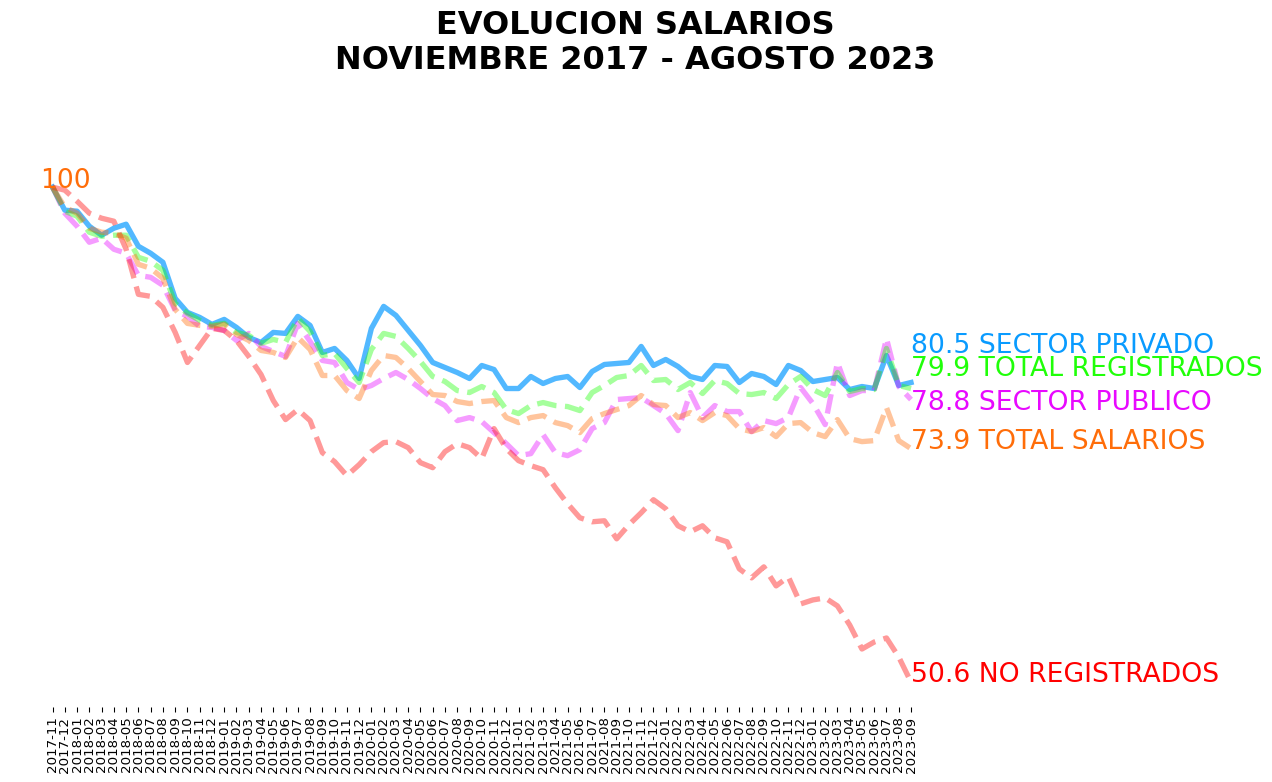

In [32]:
#En este gráfico se busca mostrar la evolución de los indicadores de salario que publica el INDEC en el periodo que va desde el mes con mayor nivel de actividad economica (EMAE)
#del gobierno anterior (MACRI), hasta el ultimo mes con información disponible.

#El nivel de salario real se obtiene deflactando por inflacion los valores del dataset

#DATASETS
ISAL = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/149/distribution/149.1/download/indice-salarios-periodicidad-mensual-base-octubre-2016.csv")
IPC = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/145/distribution/145.3/download/indice-precios-al-consumidor-nivel-general-base-diciembre-2016-mensual.csv")
EMAE = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/143/distribution/143.3/download/emae-valores-anuales-indice-base-2004-mensual.csv")

#La serie de IPC que publica el INDEC arranca en diciembre de 2016, por lo que le agrego los datos faltantes de inflacion mensual desde Enero de 2003.
#creo una lista que incluye los meses que voy a agregar al dataset IPC
meses=pd.date_range(start='1/1/2003', end='12/1/2016', freq='MS').strftime('%Y-%m-%d')
#la siguiente lista contiene los valores de inflacion mensual desde 2003-01-01	a 2016-12-01
inflacion=[0.01319,0.00566,0.00584,0.00055,-0.00384,-0.00086,0.00444,0.00024,0.00040,0.00589,0.00247,0.00212,0.00420,0.00101,0.00593,0.00858,0.00731,0.00566,0.00461,0.00343,0.00629,0.00396,0.00002,0.00836,0.01486,0.00946,
           0.01546,0.00490,0.00601,0.00916,0.01004,0.00437,0.01163,0.00781,0.01206,0.01113,0.01276,0.00396,0.01205,0.00973,0.00468,0.00484,0.00617,0.00563,0.00899,0.00856,0.00708,0.00981,0.01500,0.00900,0.00900,0.02000,
           0.02200,0.02100,0.03100,0.03700,0.02600,0.02500,0.00900,0.00800,0.01000,0.02400,0.03300,0.03000,0.01600,0.02000,0.01900,0.01300,0.01000,0.01400,0.00600,0.00600,0.00700,0.00900,0.01400,0.01100,0.00900,0.00700,
           0.01300,0.01200,0.01300,0.01600,0.01400,0.01800,0.02200,0.03400,0.02600,0.02000,0.01500,0.01200,0.01300,0.01300,0.01100,0.02600,0.02200,0.01900,0.01500,0.01400,0.02300,0.02100,0.01500,0.01300,0.01900,0.01900,
           0.01800,0.01000,0.01800,0.01800,0.01900,0.01650,0.03200,0.02160,0.01700,0.01630,0.01900,0.02310,0.01497,0.01475,0.02074,0.01973,0.02294,0.01093,0.01547,0.02006,0.01494,0.01885,0.02454,0.02079,0.02135,0.02201,
           0.02377,0.02262,0.04798,0.04375,0.03650,0.03123,0.02493,0.02336,0.02225,0.02274,0.02248,0.01928,0.01824,0.01455,0.01958,0.01453,0.01662,0.02368,0.02213,0.01350,0.02040,0.01831,0.01657,0.01702,0.01954,0.03917,
           0.04137,0.03969,0.03318,0.06545,0.05034,0.03223,0.02156,-0.00758,0.01343,0.02900,0.01980,0.01242]
#armo un nuevo dataframe juntando las dos series.
nIPC = pd.DataFrame(list(zip(meses, inflacion)),columns =['indice_tiempo', 'inflacion'])
#al dataset IPC le saco la primera fila porque no tiene la variacion mensual de 2016-12-01, y solo dejo las columnas relevantes
IPC = IPC[['indice_tiempo','ipc_ng_nacional_tasa_variacion_mensual']].iloc[1:]
#ahora voy a unir el a agregar al dataset IPC los datos historicos
IPC = pd.concat([nIPC, IPC], ignore_index=True, sort=False)
#finalmente agrego una nueva columna donde van a estar reflejados los valores de inflacion de todo el periodo
#primero pongo 0 en todos los valores vacios, y luego sumo las columnas para obtener la seria completa
IPC=IPC.fillna(0)
IPC["nueva_serie"]=IPC['ipc_ng_nacional_tasa_variacion_mensual']+IPC['inflacion']

#DEFINICION DEL PERIODO A ANALIZAR (fecha inicial y fecha final)
#la fecha final es el ultimo mes con info disponible del indicador
#iloc permite acceder al valor usando el número de posición
fecha_final=ISAL['indice_tiempo'].iloc[-1]
#la fecha inicial es el mes en el que el EMAE muestra un mayor nivel durante el gobierno anterior
#filtramos para que solo queden los datos de ese periodo de gobierno y ordenamos de menor a mayor usando la columna relevante
fecha_inicial=EMAE[(EMAE.indice_tiempo > "2015-12-01") & (EMAE.indice_tiempo < "2020-01-01")].sort_values(by='emae_desestacionalizada')
fecha_inicial= fecha_inicial.indice_tiempo.iloc[-1]

#CALCULO DEL SALARIO REAL (igual al indicador anterior)
dfs=[ISAL, IPC]
df1 = reduce(lambda  left,right: pd.merge(left,right,on=['indice_tiempo'],how='outer'), dfs)
df1=df1.loc[(df1['indice_tiempo'] >= fecha_inicial) & (df1['indice_tiempo'] <= fecha_final)].reset_index()
df1.loc[0,"nueva_serie"]=100
for i in range(1, len(df1)):
  df1.loc[i,'nueva_serie'] = df1.loc[i-1,'nueva_serie'] * (df1.loc[i,'nueva_serie'] + 1)
df1["calculo"]=df1.loc[:,'nueva_serie'].div(df1.iloc[0]['nueva_serie'])
def prueba (number):
    return number.div(df1["calculo"].values).pct_change()
columnas_corrientes=['indice_salarios', "indice_salarios_registrado", "indice_salarios_registrado_sector_privado",
                     "indice_salarios_registrado_sector_publico","indice_salarios_no_registrado_sector_privado"]
df1[columnas_corrientes] = df1[columnas_corrientes].apply(prueba)
df1.loc[0, columnas_corrientes]=100
for i in range(1, len(df1)):
  df1.loc[i, columnas_corrientes] = df1.loc[i-1, columnas_corrientes] * (df1.loc[i, columnas_corrientes]+1)

#GRAFICO
fig = plt.figure(figsize=(13.33,7.5), dpi=96)

#variables
x=df1["indice_tiempo"].str[:7]
y1=df1["indice_salarios_registrado_sector_privado"].round(1)
y2=df1["indice_salarios_registrado_sector_publico"].round(1)
y3=df1["indice_salarios_registrado"].round(1)
y4=df1["indice_salarios_no_registrado_sector_privado"].round(1)
y5=df1["indice_salarios"].round(1)

#defino las lineas y sus caracteristicas
plt.plot(x, y1, color="#099BFF", linewidth=4, alpha=0.7)
plt.plot(x, y2, color='#E809FF', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y3, color='#20FF09', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y4, color='red', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y5, color='#ff6d09', linewidth=4, alpha=0.4, linestyle='dashed')

#etiquetas eje x rotadas
plt.tick_params(axis='x', rotation=90)
#saco los ejes x e y
plt.box(False)
#saco las etiquetas del eje y
plt.yticks([])

#anotaciones en el grafico
plt.text(x.iloc[-1], y2.tail(1)-1, df1["indice_salarios_registrado_sector_publico"].iloc[-1].round(1).astype(str)+" SECTOR PUBLICO", horizontalalignment='left', color='#E809FF', fontsize=20)
plt.text(x.iloc[-1], y5.tail(1), df1["indice_salarios"].iloc[-1].round(1).astype(str)+" TOTAL SALARIOS", horizontalalignment='left',color='#ff6d09', fontsize=20)
plt.text(x.iloc[-1], y3.tail(1)+1.3, df1["indice_salarios_registrado"].iloc[-1].round(1).astype(str)+" TOTAL REGISTRADOS", horizontalalignment='left',color='#20FF09', fontsize=20)
plt.text(x.iloc[-1], y4.tail(1), df1["indice_salarios_no_registrado_sector_privado"].iloc[-1].round(1).astype(str)+" NO REGISTRADOS", horizontalalignment='left',color='red', fontsize=20)
plt.text(x.iloc[-1], y1.tail(1)+3, df1["indice_salarios_registrado_sector_privado"].iloc[-1].round(1).astype(str)+" SECTOR PRIVADO", horizontalalignment='left', color='#099BFF', fontsize=20)
plt.text(-1, y1.head(1), "100", horizontalalignment='left', color='#ff6d09', fontsize=20)


#funcion que genera el nombre de un mes en el grafico
EMAE["nombre_mes"]=EMAE["indice_tiempo"].str[5:7]
meses = {"01":"ENERO","02":"FEBRERO","03":"MARZO","04":"ABRIL","05":"MAYO","06":"JUNIO","07":"JULIO","08":"AGOSTO","09":"SEPTIEMBRE","10":"OCTUBRE","11":"NOVIEMBRE","12": "DICIEMBRE"}
EMAE['nombre_mes'].replace(meses, inplace=True)

my_suptitle = fig.suptitle("EVOLUCION SALARIOS\n"+meses[fecha_inicial[5:7]]+" "+fecha_inicial[:4]+" - "+EMAE["nombre_mes"].iloc[-1]+" "+
                           EMAE["indice_tiempo"].str[:4].iloc[-1], fontsize=24,fontweight="bold",y=1.08, color="black")
plt.tight_layout()

plt.show()

GRAFICO 3 - EVOLUCION INGRESOS (PESOS LINEA POBREZA E INDIGENCIA)

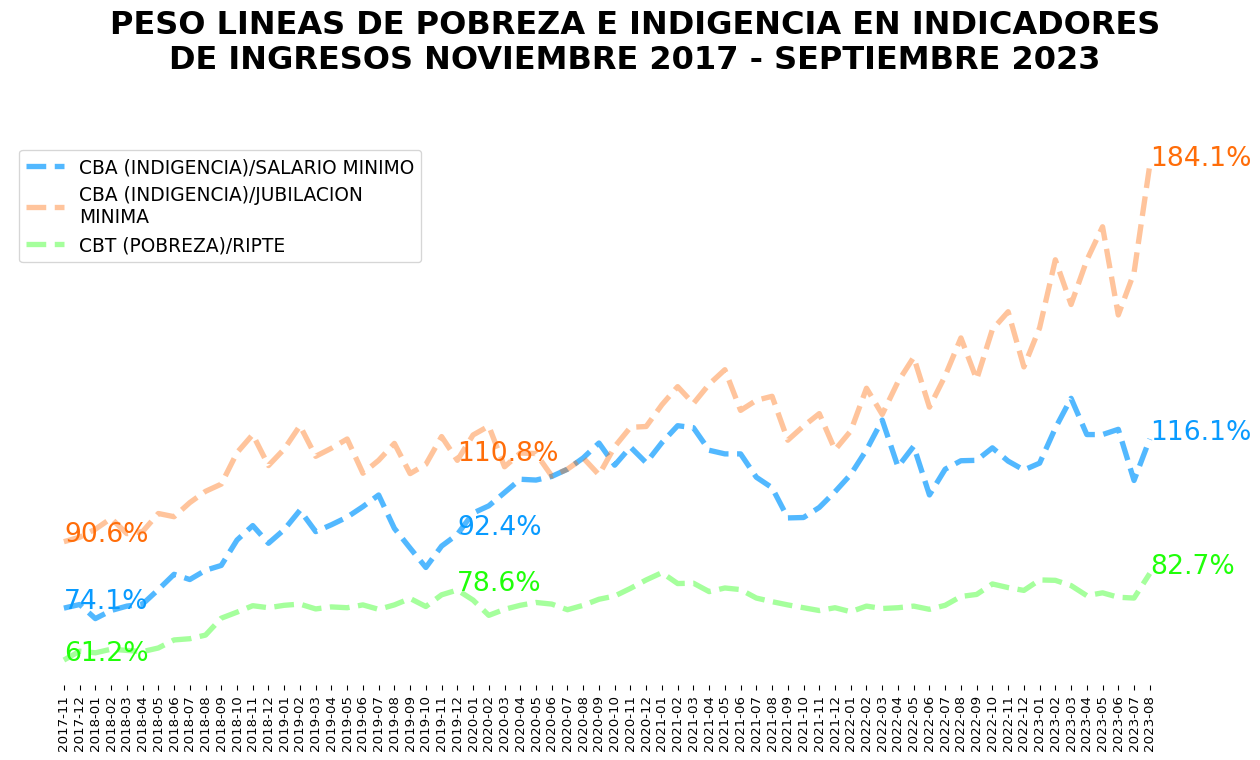

In [52]:
#En este gráfico se busca mostrar la evolución del poder adquisitivo de los ingresos, desde el mes con mayor nivel de actividad economica (EMAE) del gobierno anterior, a través de los siguientes indicadores:
#1-relación entre el valor de la CBA (Canasta basica alimentaria, que define la linea de indigencia) y el valor de la jubilación mínima.
#2-relación entre el valor de la CBA (Canasta basica alimentaria, que define la linea de indigencia) y el valor del salario mínimo.
#3-relación entre el valor de la CBT (Canasta basica total, que define la linea de pobreza) y el valor del RIPTE (remuneración promedio trabajadores en relación de dependencia).

#DATASETS
CBT = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/150/distribution/150.1/download/valores-canasta-basica-alimentos-canasta-basica-total-mensual-2016.csv")
SMVM = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/57/distribution/57.1/download/indice-salario-minimo-vital-movil-valores-mensuales-pesos-corrientes-desde-1988.csv")
RIPTE = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/158/distribution/158.1/download/remuneracion-imponible-promedio-trabajadores-estables-ripte-total-pais-pesos-serie-mensual.csv")
HMJ = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/58/distribution/58.1/download/haber-minimo-jubilatorio-pesos-corrientes-valores-mensuales-desde-1971.csv")
EMAE = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/143/distribution/143.3/download/emae-valores-anuales-indice-base-2004-mensual.csv")

#DEFINICION DEL PERIODO A ANALIZAR (fecha inicial y fecha final)
#la fecha final es el ultimo mes con info disponible del indicador
#iloc permite acceder al valor usando el número de posición
fecha_final=CBT['indice_tiempo'].iloc[-1]
#la fecha inicial es el mes en el que el EMAE muestra un mayor nivel durante el gobierno anterior
#filtramos para que solo queden los datos de ese periodo de gobierno y ordenamos de menor a mayor usando la columna relevante
fecha_inicial=EMAE[(EMAE.indice_tiempo > "2015-12-01") & (EMAE.indice_tiempo < "2020-01-01")].sort_values(by='emae_desestacionalizada')
fecha_inicial= fecha_inicial.indice_tiempo.iloc[-1]

#armo un nuevo dataframe donde queden ordenados por periodo de tiempo todos los dataset
dfs=[CBT,SMVM,RIPTE,HMJ]
df = reduce(lambda  left,right: pd.merge(left,right,on=['indice_tiempo'],how='outer'), dfs)
df=df.loc[(df['indice_tiempo'] >= fecha_inicial) & (df['indice_tiempo'] <= fecha_final)].reset_index()

#GRAFICO
fig = plt.figure(figsize=(13.33,7.5), dpi=96)

#variables
x=df["indice_tiempo"].str[:7]
y1=((df["linea_indigencia"]/df["salario_minimo_vital_movil_mensual"])*100).round(1)
y2=((df["linea_indigencia"]/df["mensual_pesos_corrientes"])*100).round(1)
y3=((df["linea_pobreza"]/df["ripte"])*100).round(1)

plt.plot(x, y1, color="#099BFF", linewidth=4, alpha=0.7, linestyle='dashed', label="CBA (INDIGENCIA)/SALARIO MINIMO")
plt.plot(x, y2, color='#ff6d09', linewidth=4, alpha=0.4, linestyle='dashed', label="CBA (INDIGENCIA)/JUBILACION\nMINIMA")
plt.plot(x, y3, color='#20FF09', linewidth=4, alpha=0.4, linestyle='dashed', label="CBT (POBREZA)/RIPTE")

#etiquetas eje x rotadas
plt.tick_params(axis='x', rotation=90)
#saco los ejes x e y
plt.box(False)
#saco las etiquetas del eje y
plt.yticks([])

#ANOTACIONES
plt.text(x.iloc[-1], y1.tail(1), y1.iloc[-1].round(1).astype(str)+"%", horizontalalignment='left', color='#099BFF', fontsize=20)
plt.text(x.iloc[-1], y2.tail(1),y2.iloc[-1].round(1).astype(str)+"%", horizontalalignment='left', color='#ff6d09', fontsize=20)
plt.text(x.iloc[-1], y3.tail(1), y3.iloc[-1].round(1).astype(str)+"%", horizontalalignment='left',  color='#20FF09', fontsize=20)
plt.text(x.iloc[0], y1.head(1), y1.iloc[0].round(1).astype(str)+"%", horizontalalignment='left',  color='#099BFF', fontsize=20)
plt.text(x.iloc[0], y2.head(1), y2.iloc[0].round(1).astype(str)+"%", horizontalalignment='left',  color='#ff6d09', fontsize=20)
plt.text(x.iloc[0], y3.head(1), y3.iloc[0].round(1).astype(str)+"%", horizontalalignment='left',  color='#20FF09', fontsize=20)
plt.text(x.iloc[25], y1[25], y1.iloc[25].round(1).astype(str)+"%", horizontalalignment='left',  color='#099BFF', fontsize=20)
plt.text(x.iloc[25], y2[25], y2.iloc[25].round(1).astype(str)+"%", horizontalalignment='left',  color='#ff6d09', fontsize=20)
plt.text(x.iloc[25], y3[25], y3.iloc[25].round(1).astype(str)+"%", horizontalalignment='left', color='#20FF09', fontsize=20)

#funcion que genera el nombre de un mes en el grafico
RIPTE["nombre_mes"]=RIPTE["indice_tiempo"].str[5:7]
meses = {"01":"ENERO","02":"FEBRERO","03":"MARZO","04":"ABRIL","05":"MAYO","06":"JUNIO","07":"JULIO","08":"AGOSTO","09":"SEPTIEMBRE","10":"OCTUBRE","11":"NOVIEMBRE","12": "DICIEMBRE"}
RIPTE['nombre_mes'].replace(meses, inplace=True)

plt.legend(fontsize=14)

my_suptitle = fig.suptitle("PESO LINEAS DE POBREZA E INDIGENCIA EN INDICADORES\nDE INGRESOS "+meses[fecha_inicial[5:7]]+" "+fecha_inicial[:4]+" - "+
                           RIPTE["nombre_mes"].iloc[-1]+" "+RIPTE["indice_tiempo"].str[:4].iloc[-1], fontsize=24,fontweight="bold",y=1.05, color="black")

plt.tight_layout()

plt.show()

GRAFICO 4 - EVOLUCION INGRESOS (PESOS LINEA POBREZA E INDIGENCIA)

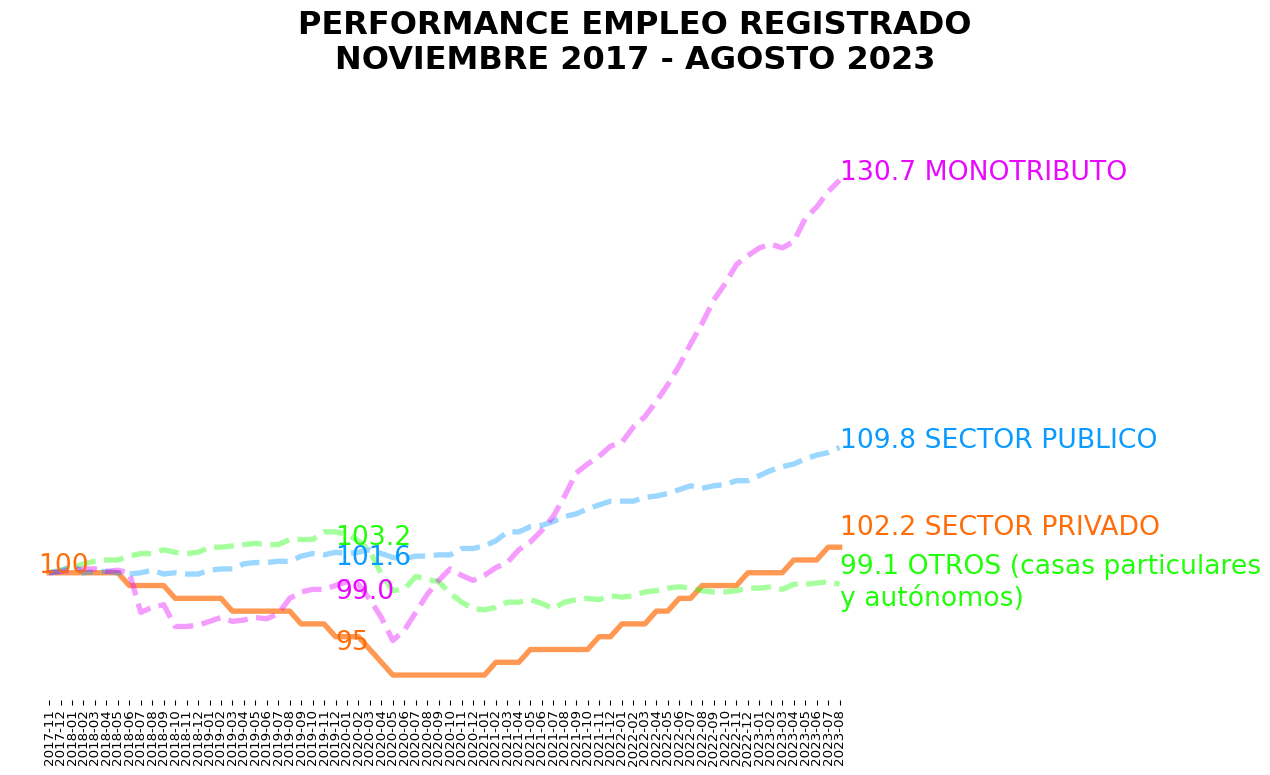

In [57]:
#En este gráfico se busca mostrar la evolución de la cantidad de trabajador@s, desde el mes con mayor nivel de actividad economica (EMAE) del gobierno anterior al ultimo mes con informacion

#DATASET
TRA = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/151/distribution/151.1/download/trabajadores-registrados-modalidad-ocupacional-principal-mensual-total-pais-miles-base-2012.csv")
EMAE = pd.read_csv("https://infra.datos.gob.ar/catalog/sspm/dataset/143/distribution/143.3/download/emae-valores-anuales-indice-base-2004-mensual.csv")

#creo dos categorias nuevas, que nuclean 2 en 1 cada una
TRA["otros"]=TRA['asalariados_casas_particulares_sin_estac']+TRA['independientes_autonomos_sin_estac']
TRA["monotributo"]=TRA["independientes_monotributo_sin_estac"]+TRA["independientes_monotributo_social_sin_estac"]

#DEFINICION DEL PERIODO A ANALIZAR (fecha inicial y fecha final)
#la fecha final es el ultimo mes con info disponible del indicador
#iloc permite acceder al valor usando el número de posición
fecha_final=TRA['indice_tiempo'].iloc[-1]
#la fecha inicial es el mes en el que el EMAE muestra un mayor nivel durante el gobierno anterior
#filtramos para que solo queden los datos de ese periodo de gobierno y ordenamos de menor a mayor usando la columna relevante
fecha_inicial=EMAE[(EMAE.indice_tiempo > "2015-12-01") & (EMAE.indice_tiempo < "2020-01-01")].sort_values(by='emae_desestacionalizada')
fecha_inicial= fecha_inicial.indice_tiempo.iloc[-1]

#OBTENGO UN DATAFRAME DE LOS INDICADORES SELECCIONADOS EN EL PERIODO ELEGIDO
indicadores=['asalariados_priv_sin_estac',"otros",'asalariados_pub_sin_estac','monotributo']
dfs=[TRA]
df = reduce(lambda  left,right: pd.merge(left,right,on=['indice_tiempo'],how='outer'), dfs)
df=df.loc[(df['indice_tiempo'] >= fecha_inicial) & (df['indice_tiempo'] <= fecha_final)].reset_index()

#CALCULO DE LAS SERIES CON BASE 100
def prueba (number):
    return number.pct_change()
df[indicadores] = df[indicadores].apply(prueba)
df.loc[0, indicadores]=100
for i in range(1, len(df)):
  df.loc[i, indicadores] = df.loc[i-1, indicadores] * (df.loc[i, indicadores]+1)

#GRAFICO
fig = plt.figure(figsize=(13.33,7.5), dpi=96)

#variables
x=df["indice_tiempo"].str[:7]
y1=df["asalariados_priv_sin_estac"].astype(int)
y2=df["otros"].round(1)
y3=df["asalariados_pub_sin_estac"].round(1)
y4=df["monotributo"].round(1)

plt.plot(x, y1, color="#ff6d09", linewidth=4, alpha=0.7)
plt.plot(x, y2, color='#20FF09', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y3, color='#099BFF', linewidth=4, alpha=0.4, linestyle='dashed')
plt.plot(x, y4, color='#E809FF', linewidth=4, alpha=0.4, linestyle='dashed')

#etiquetas eje x rotadas
plt.tick_params(axis='x', rotation=90)
#saco los ejes x e y
plt.box(False)
#saco las etiquetas del eje y
plt.yticks([])

#ANOTACIONES EN EL GRAFICO
valor_indice=x[x == "2019-12"].index[0]
plt.text(x.tail(1), y2.tail(1)-1.7, df["otros"].iloc[-1].round(1).astype(str)+" OTROS (casas particulares\ny autónomos)", horizontalalignment='left',  color='#20FF09', fontsize=20)
plt.text(x.tail(1), y3.tail(1), df["asalariados_pub_sin_estac"].iloc[-1].round(1).astype(str)+" SECTOR PUBLICO", horizontalalignment='left', color='#099BFF', fontsize=20)
plt.text(x.tail(1), y4.tail(1), df["monotributo"].iloc[-1].round(1).astype(str)+" MONOTRIBUTO", horizontalalignment='left', color='#E809FF', fontsize=20)
plt.text(x.tail(1), y1.tail(1)+1, df["asalariados_priv_sin_estac"].iloc[-1].round(1).astype(str)+" SECTOR PRIVADO", horizontalalignment='left', color='#ff6d09', fontsize=20)
plt.text(-1, y1.head(1), "100", horizontalalignment='left', color='#ff6d09', fontsize=20)
plt.text("2019-12", y1[valor_indice]-1, y1[valor_indice].astype(str), horizontalalignment='left',  color='#ff6d09', fontsize=20)
plt.text("2019-12", y2[valor_indice]-1, y2[valor_indice].astype(str), horizontalalignment='left',  color='#20FF09', fontsize=20)
plt.text("2019-12", y3[valor_indice]-1, y3[valor_indice].astype(str), horizontalalignment='left',  color='#099BFF', fontsize=20)
plt.text("2019-12", y4[valor_indice]-1, y4[valor_indice].astype(str), horizontalalignment='left',  color='#E809FF', fontsize=20)

#funcion que genera el nombre de un mes en el grafico
TRA["nombre_mes"]=TRA["indice_tiempo"].str[5:7]
meses = {"01":"ENERO","02":"FEBRERO","03":"MARZO","04":"ABRIL","05":"MAYO","06":"JUNIO","07":"JULIO","08":"AGOSTO","09":"SEPTIEMBRE","10":"OCTUBRE","11":"NOVIEMBRE","12": "DICIEMBRE"}
TRA['nombre_mes'].replace(meses, inplace=True)

my_suptitle = fig.suptitle("PERFORMANCE EMPLEO REGISTRADO\n"+meses[fecha_inicial[5:7]]+" "+fecha_inicial[:4]+" - "+TRA["nombre_mes"].iloc[-1]+" "+TRA["indice_tiempo"].str[:4].iloc[-1], fontsize=24,fontweight="bold",y=1.07, color="black")
plt.tight_layout()

plt.tight_layout()

plt.show()